### Strategy

Featurization will occur over time, holding only a few days in RAM at a time.

In [1]:
# Libraries
import os 
import pickle 
import itertools 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import progress_bar as pb 
import sklearn.ensemble 
from sklearn.metrics import mean_squared_error 
from sklearn.utils import shuffle 
from datetime import datetime
from multiprocessing.pool import ThreadPool 
from pathlib import Path 

In [2]:
# Load data 
holidays_df = pd.read_csv('data/holidays_events.csv') 
items_df = pd.read_csv('data/items.csv') 
oil_df = pd.read_csv('data/oil.csv') 
stores_df = pd.read_csv('data/stores.csv') 
txns_df = pd.read_csv('data/transactions.csv') 
test_df = pd.read_csv('data/test.csv') 
out_df = pd.read_csv('data/sample_submission.csv') 

In [3]:
# Get training data file paths 
date_dir = 'data/train_partitioned_by_day/' 
test_date_dir = 'data/test_partitioned_by_day/'
date_file_names = os.listdir( date_dir ) 
date_file_names.extend( os.listdir( test_date_dir ) ) 
dates_str = [ x.split('_')[1].split('.')[0] for x in date_file_names ] 
dates_dict_str_to_npdatetime64 = dict(zip( dates_str , np.array( dates_str , dtype='datetime64' ) ))  
dates_dict_str_to_int = dict(zip( dates_str , [ x.astype('uint64') for x in np.array( dates_str , dtype='datetime64' ) ] )) 
dates_dict_int_to_str = dict(zip( [ x.astype('uint64') for x in np.array( dates_str , dtype='datetime64' ) ] , dates_str )) 

# get date sorted date strings 
date_min_idx = np.min( dates_dict_str_to_int.values() ) 
date_max_idx = np.max( dates_dict_str_to_int.values() ) 
print( 'min date idx: ' + str(date_min_idx) + ', max date idx: ' + str(date_max_idx) )
date_idxs = range( int(date_min_idx) , int(date_max_idx+1) ) 
sorted_date_strs = pd.to_datetime( date_idxs , unit='D' ).strftime('%Y-%m-%d') # includes a few for which no files exist 
date_dict_idx_to_str = dict(zip( date_idxs , sorted_date_strs )) 

min date idx: 15706, max date idx: 17409


In [4]:
# Interpolate missing oil prices 

# This loop adds missing prices, but some dates are still missing too!  
oil_df.iloc[ 0 , 1 ] = 93.14 
prev_price = 93.14 
for i in range( oil_df.shape[0] ) : 
    if np.isnan( oil_df.iloc[i,1] ) : 
        oil_df.iloc[i,1] = prev_price 
    prev_price = oil_df.iloc[ i , 1 ] 

# Convert to dict with no missing dates 
oil_dict = {} 
last_price = 93.14 
for date in sorted_date_strs : 
    try : 
        last_price = oil_df.loc[ oil_df['date'] == date , 'dcoilwtico' ].iloc[0] 
        oil_dict[ date ] = last_price 
    except : 
        oil_dict[ date ] = last_price 

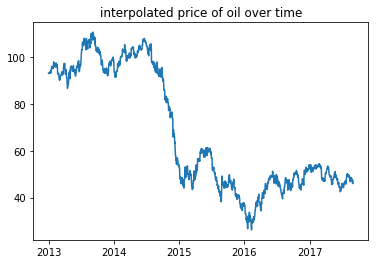

In [5]:
# Test conversion with a plot 
oil_date = [] 
oil_price = [] 
for date_str in sorted_date_strs : 
    oil_date.append( datetime.strptime( date_str , '%Y-%m-%d' ) ) 
    oil_price.append( oil_dict[ date_str ] ) 

plt.plot( oil_date , oil_price ) 
plt.title( 'interpolated price of oil over time' )
plt.show()

In [6]:
# Load all data, one day at a time 
first_test_date_idx = 17394

def load_raw_training_data() : 
    date_dict_str_to_df = dict() 
    for i in pb.log_progress(date_idxs , every=10 ) : 
        date_str = date_dict_idx_to_str[i] 
        path = None 
        if i < first_test_date_idx : # traing dates 
            path = date_dir + 'date_' + date_str + '.csv' 
        else : # testing dates  
            path = test_date_dir + 'date_' + date_str + '.csv' 
        if os.path.exists( path ) : 
            date_dict_str_to_df[ date_str ] = pd.read_csv( path ) 
        else : 
            date_dict_str_to_df[ date_str ] = None 
    return date_dict_str_to_df 

date_dict_str_to_df = [] # load_raw_training_data() # loaded only if necessary  

In [7]:
## Example 
#example_row = date_dict_str_to_df[ sorted_date_strs[0] ].iloc[0]
#print( 'Example row:\n' + str( example_row ) ) 
## Access it like a dictionary 
#print( "\nexample_row['item_nbr']: " + str( example_row['item_nbr'] ) )

## Featurization 

All predictions will be made available for (product, store, date) (**psd**) triples, since the test set is composed according to such.

In [9]:
all_products = items_df['item_nbr'].unique() 
all_stores = stores_df['store_nbr'].unique() 
all_date_idxs = date_idxs # previously constructed 
# psd_triples = itertools.product( all_products , all_stores , all_date_idxs ) 
# psd_triples = [ [ x[0] , x[1] , x[2] ] for x in psd_triples ] # RAM usage too great 
max_lag = 101 # autocorrelative statistics may be taken up to time max_lag 
predictive_horizon = len(all_date_idxs) - 16 - 16 # - predictive duration - testing dates 
psd_triples_len = len(all_products) * len(all_stores) * len(all_date_idxs[max_lag:predictive_horizon]) 
# print( 'len(psd_triples): ' + str( psd_triples_len ) ) # 373723200 
# Too many features to compute on one node, so we'll use a random subset. 
# Use itertools.islice to quickly jump through psd_triples. 

SAMPLE_SIZE = 100000 # about 24 hrs of compute per 100K data 
sample_idx = np.random.randint( low=0 , high = psd_triples_len-1 , size = SAMPLE_SIZE )

def feature_encode_units_sales ( psd , time_del=0 ) :
    item_nbr  = psd[0] 
    store_nbr = psd[1]
    date_idx  = psd[2] + time_del 
    date_str = date_dict_idx_to_str[ date_idx ] 
    date_df = date_dict_str_to_df[ date_str ] 
    if date_df is None : 
        return [0] 
    unit_sales = date_df[ 'unit_sales' ].loc[ ( date_df[ 'item_nbr' ] == item_nbr ) 
                                 & ( date_df[ 'store_nbr' ] == store_nbr ) 
                                 & ( date_df[ 'date' ] == date_str ) ] 
    if len(unit_sales) == 0 : 
        return [0] 
    unit_sales = unit_sales.iloc[0] 
    if unit_sales < 0. : 
        return [0] 
    return [ np.log1p( unit_sales ) ] 

def feature_encode_perishable ( psd ) : 
    return [ items_df.loc[ items_df['item_nbr'] == psd[0] , 'perishable' ].iloc[0] ] 

def feature_encode_store ( psd ) :
    store_nbr = psd[1] 
    one_hot = np.zeros( 54 ) # 54 locations total 
    one_hot[ store_nbr-1 ] = 1 
    return one_hot 

def feature_encode_item_family ( psd ) :
    item_nbr = psd[0] 
    family = items_df.loc[ items_df['item_nbr'] == item_nbr , 'family' ].iloc[0] # returns a series of one item 
    one_hot = np.zeros( 33 ) 
    one_hot[ feature_encode_item_family.family_dict[ family ] ] = 1 
    return one_hot 
feature_encode_item_family.family_dict = dict(zip( items_df['family'].unique() , range(33) )) 

def feature_encode_item_class ( psd ) :
    item_nbr = psd[0] 
    class_fe = items_df.loc[ items_df['item_nbr'] == item_nbr , 'class' ].iloc[0] 
    one_hot = np.zeros( 337 ) # 337 total classes 
    one_hot[ feature_encode_item_class.class_dict[ class_fe ] ] = 1 
    return one_hot
feature_encode_item_class.class_dict = dict( zip( items_df['class'].unique() , range(337) ) )

def feature_encode_total_sales_by_family ( psd , date_lag=1 ) :
    '''Calculates the average unit_sales for a given date_df,
    thereby allowing autoregression.'''
    item_nbr = psd[0] 
    date_idx = psd[2] - date_lag 
    if date_idx < date_min_idx : 
        return [0.] 
    date_df = date_dict_str_to_df[ date_dict_idx_to_str[ date_idx ] ] 
    if date_df is None : 
        return [0.] 
    item_family = items_df.loc[ items_df['item_nbr'] == item_nbr , 'family' ].iloc[0] 
    items = items_df.loc[ items_df['family'] == item_family , 'item_nbr' ] 
    sales = date_df.loc[ (date_df['item_nbr'].isin(items) ) , 'unit_sales' ] 
    if len(sales) == 0 : 
        return [0.] 
    total = sales.sum() 
    if total < 0. : 
        total = 0.  
    return [total] 

def feature_encode_total_sales_by_class (psd , date_lag=1 ) :
    item_nbr = psd[0] 
    date_idx = psd[2] - date_lag 
    if date_idx < date_min_idx : 
        return [0.] 
    date_df = date_dict_str_to_df[ date_dict_idx_to_str[ date_idx ] ] 
    if date_df is None : 
        return [0.] 
    item_class = items_df.loc[ items_df['item_nbr'] == item_nbr , 'class' ].iloc[0]
    items = items_df.loc[ items_df['class'] == item_class , 'item_nbr' ] 
    sales = date_df.loc[ date_df['item_nbr'].isin(items) , 'unit_sales' ] 
    if len(sales) == 0 : 
        return [0.] 
    total = sales.sum() 
    if total < 0. : 
        total = 0.  
    return [total] 

def feature_encode_promotion ( psd ) :
    item_nbr  = psd[0] 
    store_nbr = psd[1]
    date_idx  = psd[2] 
    date_str = date_dict_idx_to_str[ date_idx ] 
    date_df = date_dict_str_to_df[ date_str ] 
    if date_df is None : 
        return [-1] 
    promo = date_df[ 'onpromotion' ].loc[ ( date_df[ 'item_nbr' ] == item_nbr ) 
                                 & ( date_df[ 'store_nbr' ] == store_nbr ) 
                                 & ( date_df[ 'date' ] == date_str ) ] 
    if len( promo ) == 0 : 
        return [-2] 
    promo = promo.iloc[0] 
    if np.isnan( promo ) : 
        return [-3] 
    return [promo] 

def feature_encode_time ( psd ) : 
    return [ psd[2] ]

def feature_encode_day_of_year ( psd ) : 
    date_str = date_dict_idx_to_str[ psd[2] ] 
    return [ datetime.strptime( date_str , '%Y-%m-%d' ).timetuple().tm_yday ]

def feature_encode_day_of_week ( psd ) : 
    date_str = date_dict_idx_to_str[ psd[2] ] 
    return [ datetime.strptime( date_str , '%Y-%m-%d' ).timetuple().tm_wday ] 

def feature_encode_oil( psd ) : 
    date_idx  = psd[2] 
    date_str = date_dict_idx_to_str[ date_idx ] 
    return [ oil_dict[ date_str ] ]
    # print( 'DEBUG 1: ' + str(oil_df.loc[ oil_df['date'] == date_str , 'dcoilwtico' ]) )
    # return [ oil_df.loc[ oil_df['date'] == date_str , 'dcoilwtico' ].iloc[0] ] 

def build_feature_vector ( psd ) : 
    features = [] 
    for i in range(16) : # test range is over 16 time steps  
        features.extend( feature_encode_units_sales( psd , time_del=i ) ) 
    features.extend( feature_encode_perishable( psd ) ) 
    features.extend( feature_encode_store( psd ) ) 
    features.extend( feature_encode_item_family( psd ) ) 
    features.extend( feature_encode_item_class( psd ) )  
    features.extend( feature_encode_total_sales_by_family( psd ) ) 
    features.extend( feature_encode_total_sales_by_class( psd ) ) 
    features.extend( feature_encode_promotion( psd ) ) 
    features.extend( feature_encode_time( psd ) ) 
    features.extend( feature_encode_day_of_year( psd ) ) 
    features.extend( feature_encode_day_of_week( psd ) ) 
    features.extend( feature_encode_oil( psd ) ) 
    # Autocorrelative features 
    for i in range(1,11) : 
        features.extend( feature_encode_units_sales( psd , time_del=-i ) ) 
        features.extend( feature_encode_total_sales_by_family( psd , date_lag=i ) )  
        features.extend( feature_encode_total_sales_by_class( psd , date_lag=i ) ) 
    for i in range(1,11) : 
        features.extend( feature_encode_units_sales( psd , time_del=-i*10 ) ) 
        features.extend( feature_encode_total_sales_by_family( psd , date_lag=i*10 ) ) 
        features.extend( feature_encode_total_sales_by_class( psd , date_lag=i*10 ) ) 
    return features 

# Uniquely index the cartesian product (all_products X all_stores X all_date_idxs) 
def index_to_tuple ( idx ) : 
    i = idx % len(all_products) 
    j = (idx / len(all_products)) % len(all_stores) 
    k = (idx / (len(all_products)*len(all_stores))) % len(all_date_idxs[max_lag:predictive_horizon]) 
    return ( all_products[i] , all_stores[j] , all_date_idxs[max_lag:predictive_horizon][k] ) , (i,j,k) 

def triple_to_index ( i , j , k ) : 
    '''inverse to index_to_tuple''' 
    return i + j*len(all_products) + k*len(all_products)*len(all_date_idxs[max_lag:predictive_horizon]) 

# Compute featurization 
def compute_featurization ( future_projection=0 ) : 
    data = [] 
    for idx in pb.log_progress( sample_idx , every=1 ) : 
        psd , _ = index_to_tuple( idx ) 
        data.append( build_feature_vector( psd )  ) 
    return data 

#test_psd , _ = index_to_tuple( 0 ) 
#test_feature_vector = build_feature_vector( test_psd ) 
#print( 'Number of features: ' + str(len( test_feature_vector )) ) 

In [11]:
# Run featurization 
data = None 
if Path('data/training_data_matrix.csv').exists() : 
    # load it 
    data = pd.read_csv('data/training_data_matrix.csv').as_matrix()[:,1:] 
else : 
    # load requisite data 
    date_dict_str_to_df = [] # load_raw_training_data() 
    # compute it 
    data = compute_featurization() # This NEVER finishes! I computed it on AWS with Apache Spark.  
    # save it, because that took too long! 
    # np.savetxt( 'training_data_matrix.txt' , np.array(data)) # don't overwrite spark data  

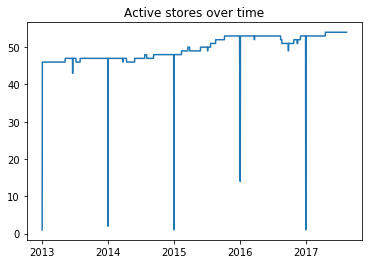

In [12]:
active_stores_per_time = txns_df.groupby('date')['store_nbr'].nunique() 
active_stores_times = np.array( txns_df['date'].unique() , dtype='datetime64' )
plt.plot( active_stores_times , active_stores_per_time )
plt.title( 'Active stores over time' )
plt.show()

## Data formatting

In [13]:
# Reshape data 
data = np.array(data)

data = shuffle( data ) 

y = data[:,:16] 
x = data[:,16:] 
weights = [ w*0.25 + 1. for w in x[:,0] ] 

offset = int( np.floor( SAMPLE_SIZE * .9 ) ) 
x_train, y_train = x[:offset], y[:offset]
x_valid, y_valid = x[offset:], y[offset:]
weights = weights[:offset]

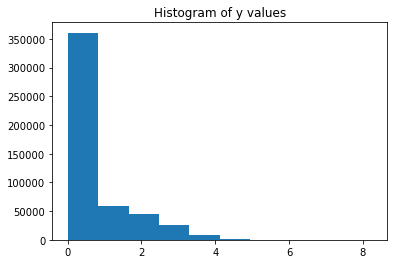

In [14]:
plt.hist( y[:,0] ) 
plt.title( 'Histogram of y values' )
plt.show()

## Boosting

In [15]:
model_paths = [ 'models/model_' + str(i) + '.pickle' for i in range(16) ] 
models = None 

def save_models( models ) : 
    for i in range(16) : 
        with open( model_paths[i] , 'wb') as handle : 
            pickle.dump( models[i] , handle, protocol=pickle.HIGHEST_PROTOCOL)

def train_model ( i ) : 
    gbr = sklearn.ensemble.GradientBoostingRegressor() 
    gbr.fit( x_train , y_train[:,i] , sample_weight = weights ) 
    return gbr

def train_models() : 
    # multi-thread 
    pool = ThreadPool( 8 ) 
    pool_out = [ pool.apply_async( train_model , (i,) ) for i in range(16) ] 
    
    models = [] 
    for i in pb.log_progress( range(16) , every=1 ) : 
        models.append( pool_out[i].get() ) 
    return models 

def load_models() : 
    models = []
    for i in pb.log_progress( range(16) , every=1 ) : 
        with open( model_paths[i] , 'rb') as handle : 
            models.append( pickle.load(handle) ) 
    return models 

def get_models() : 
    models_exist = [ Path( model_paths[i] ).exists() for i in range(16) ] 
    if all( models_exist ) : 
        return load_models() 
    models = train_models() 
    save_models( models ) 
    return models 

In [16]:
models = get_models() 

Widget Javascript not detected.  It may not be installed or enabled properly.


## Evaluation

In [17]:
# Training MSE 
mse_train_list = [] 
mse_valid_list = [] 
for i in pb.log_progress( range(16) , every=1 ) : 
    mse_train_list.append( mean_squared_error(y_train[:,i], models[i].predict(x_train) ) )
    mse_valid_list.append( mean_squared_error(y_valid[:,i], models[i].predict(x_valid) ) )

mse_train = np.mean( mse_train_list ) 
mse_valid = np.mean( mse_valid_list ) 
print( 'training MSE: ' + str(mse_train) + ', validating MSE: ' + str(mse_valid) ) 

Widget Javascript not detected.  It may not be installed or enabled properly.


training MSE: 0.262622586444, validating MSE: 0.267411714428


## Construct predictions for Kaggle

In [18]:
def build_testing_feature_vector ( psd ) : 
    features = [] 
    # I've just commented out y-vector construction 
    #####################
    #for i in range(16) : # test range is over 16 time steps  
    #    features.extend( feature_encode_units_sales( psd , time_del=i ) ) 
    features.extend( feature_encode_perishable( psd ) ) 
    features.extend( feature_encode_store( psd ) ) 
    features.extend( feature_encode_item_family( psd ) ) 
    features.extend( feature_encode_item_class( psd ) )  
    features.extend( feature_encode_total_sales_by_family( psd ) ) 
    features.extend( feature_encode_total_sales_by_class( psd ) ) 
    features.extend( feature_encode_promotion( psd ) ) 
    features.extend( feature_encode_time( psd ) ) 
    features.extend( feature_encode_day_of_year( psd ) ) 
    features.extend( feature_encode_day_of_week( psd ) ) 
    features.extend( feature_encode_oil( psd ) ) 
    # Autocorrelative features 
    for i in range(1,11) : 
        features.extend( feature_encode_units_sales( psd , time_del=-i ) ) 
        features.extend( feature_encode_total_sales_by_family( psd , date_lag=i ) )  
        features.extend( feature_encode_total_sales_by_class( psd , date_lag=i ) ) 
    for i in range(1,11) : 
        features.extend( feature_encode_units_sales( psd , time_del=-i*10 ) ) 
        features.extend( feature_encode_total_sales_by_family( psd , date_lag=i*10 ) ) 
        features.extend( feature_encode_total_sales_by_class( psd , date_lag=i*10 ) ) 
    return features 
def build_testing_features() : 
    x_test = [ [] for _ in range(16) ] # tensor of design matrices indexed over time 
    x_test_keys = [ [] for _ in range(16) ]
    for i in pb.log_progress( range( out_df.shape[0] ) , every=1 ) : 
        key = out_df['id'].iloc[i] 
        # get psd 
        p = test_df.loc[ test_df['id'] == key , 'item_nbr' ].iloc[0] 
        s = test_df.loc[ test_df['id'] == key , 'store_nbr' ].iloc[0] 
        d = first_test_date_idx # All testing data is predicted from the same point in time.   
        psd = (p,s,d) 
        idx = int(d - first_test_date_idx)
        x_test[ idx ].append( build_testing_feature_vector( psd ) ) 
        x_test_keys[ idx ].append( key ) 
    return np.array(x_test) , np.array(x_test_keys) 

x_test_file = 'data/testing_featurized.csv' 
#x_test_keys_file = 'testing_data_keys.txt' 

x_test = None
x_test_keys = None 
if Path(x_test_file).exists() : # and Path(x_test_keys_file).exists() : 
    x_test = pd.read_csv( x_test_file ).as_matrix() 
    x_test_keys = x_test[:,0] 
    x_test = x_test[:,1:] 
else : 
    x_test , x_test_keys = build_testing_features() # MUST BE COMPUTED ON SPARK ! 
    #np.savetxt( x_test_file , x_test ) 
    #np.savetxt( x_test_keys_file , x_keys_test ) # don't overwrite spark data 

In [37]:
# Make predictions 
y_test = [] 
for i in pb.log_progress( range(16) , every=1 ) : 
    y_test.append( models[i].predict( x_test ) ) 

# construct data frame 
pred_dict = { 'id' : range(125497040,128867503+1) , 'unit_sales' : np.concatenate( y_test ) } 
predictions = pd.DataFrame( data = pred_dict ) 
predictions['unit_sales'] = predictions['unit_sales'].apply( lambda(x) : np.exp(x)-1.0 ) # get out of log-scale 
# write predictions to disk 
predictions.to_csv( "submission2.csv" , index=False ) 

Widget Javascript not detected.  It may not be installed or enabled properly.
